# CLAP Few Shot learning using Contrastive Losses


This notebook implements a **few-shot audio classification system** for distinguishing between cat and dog sounds using contrastive learning techniques. The system leverages a pre-trained CLAP (Contrastive Language-Audio Pre-training) model as a frozen feature extractor and trains only a small projection head using limited labeled data. (5 samples per class)



### 1. **Contrastive Learning Approaches**

The notebook implements two distinct contrastive learning strategies:

#### **Triplet-Based Contrastive Loss**
- Uses **anchor-positive-negative triplets** where:
 - Anchor: reference audio sample
 - Positive: different sample from same class (cat/dog)
 - Negative: sample from different class
- **Margin Ranking Loss**: Encourages `similarity(anchor, positive) > similarity(anchor, negative) + margin`
- Good for learning discriminative features when you have clear positive/negative pairs

#### **Supervised Contrastive Loss **
- Treats all samples from the same class as positives
- Uses **temperature-scaled cosine similarities** to create probability distributions. This controls softmax sharpness in supervised contrastive loss
- More robust to batch composition and can leverage multiple positives simultaneously
- Formula: $- \log\!\left(\frac{\sum \exp\!\bigl(\tfrac{\mathrm{sim\_positive}}{\tau}\bigr)}{\sum \exp\!\bigl(\tfrac{\mathrm{sim\_all}}{\tau}\bigr)}\right)$


### 2. **Few-Shot Learning Strategy**

- CLAP model parameters are frozen to prevent overfitting
- Only a small linear layer (512 to 128 dimensions) is trained


### 3. **Class Imbalance Handling by Oversampling Strategy**
- `Explained in Discussion:` Over sample Cat class due to validation confusion matix.


### 4. **Evaluation Strategy : Centroid-Based and KNN Classification**
- `For Centroid Approach`: Computes class centroids from training embeddings and classifies test samples by nearest centroid (cosine similarity)
- `For KNN Approach`: Computes normalized embeddings for all training samples, and classifies each evaluation sample by finding its k most similar train embeddings (cosine similarity) and using majority vote among their labels.
- No additional classifier training required

### 5. **Embedding Visualization**

- Visualizes learned embeddings in 2D space
- Monitors clustering quality across training epochs
- Helps diagnose if contrastive learning is creating meaningful separations


In [1]:
import os
import random
import numpy as np
import torch
import torchaudio
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import ClapProcessor, ClapModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from pathlib import Path
import pytorch_lightning as pl

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    pl.seed_everything(seed, workers=True)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_all_seeds(42)

# Configuration
CONFIG = {
    "data_dir": "data/cat_dog_audio",
    "balance_method": "oversample",
    "oversample_multiplier": 2,
    "few_shot_per_class": 5,
    "batch_size": 8,
    "epochs": 10,
    "lr": 1e-6,
}


Seed set to 42


In [2]:
from src.plots import audio_eda, plot_sample_waveforms
from src.plots import audio_eda, plot_sample_waveforms
from src.training import train_contrastive_model, train_supervised_contrastive_model


In [3]:
def download_kaggle(dest):
    if dest.exists() and list(dest.rglob("*.wav")):
        return
    dest.mkdir(parents=True, exist_ok=True)
    os.system(f"kaggle datasets download -d mmoreaux/audio-cats-and-dogs -p {dest} --unzip")
download_kaggle(Path(CONFIG["data_dir"]))

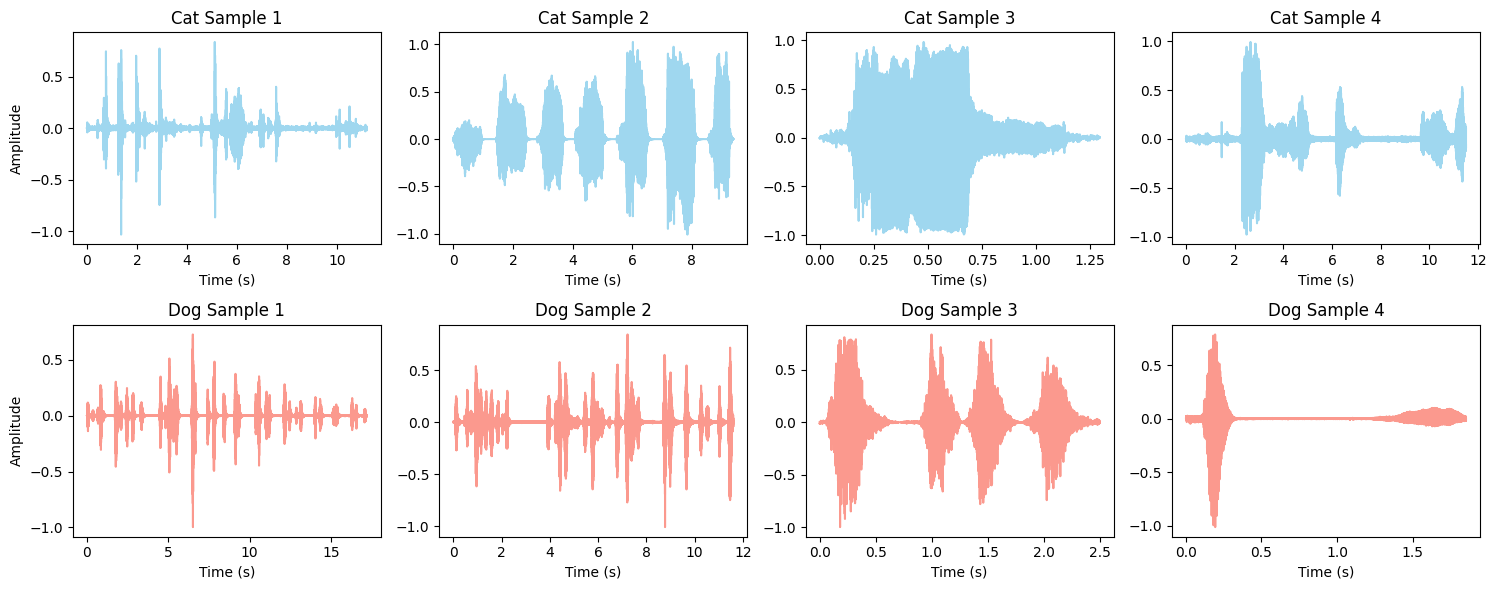

In [4]:
plot_sample_waveforms("data/cat_dog_audio")

e:\Studies\few-shot-audio-classifier-main\src\plots.py:35: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  duration = librosa.get_duration(filename=str(wav_path))


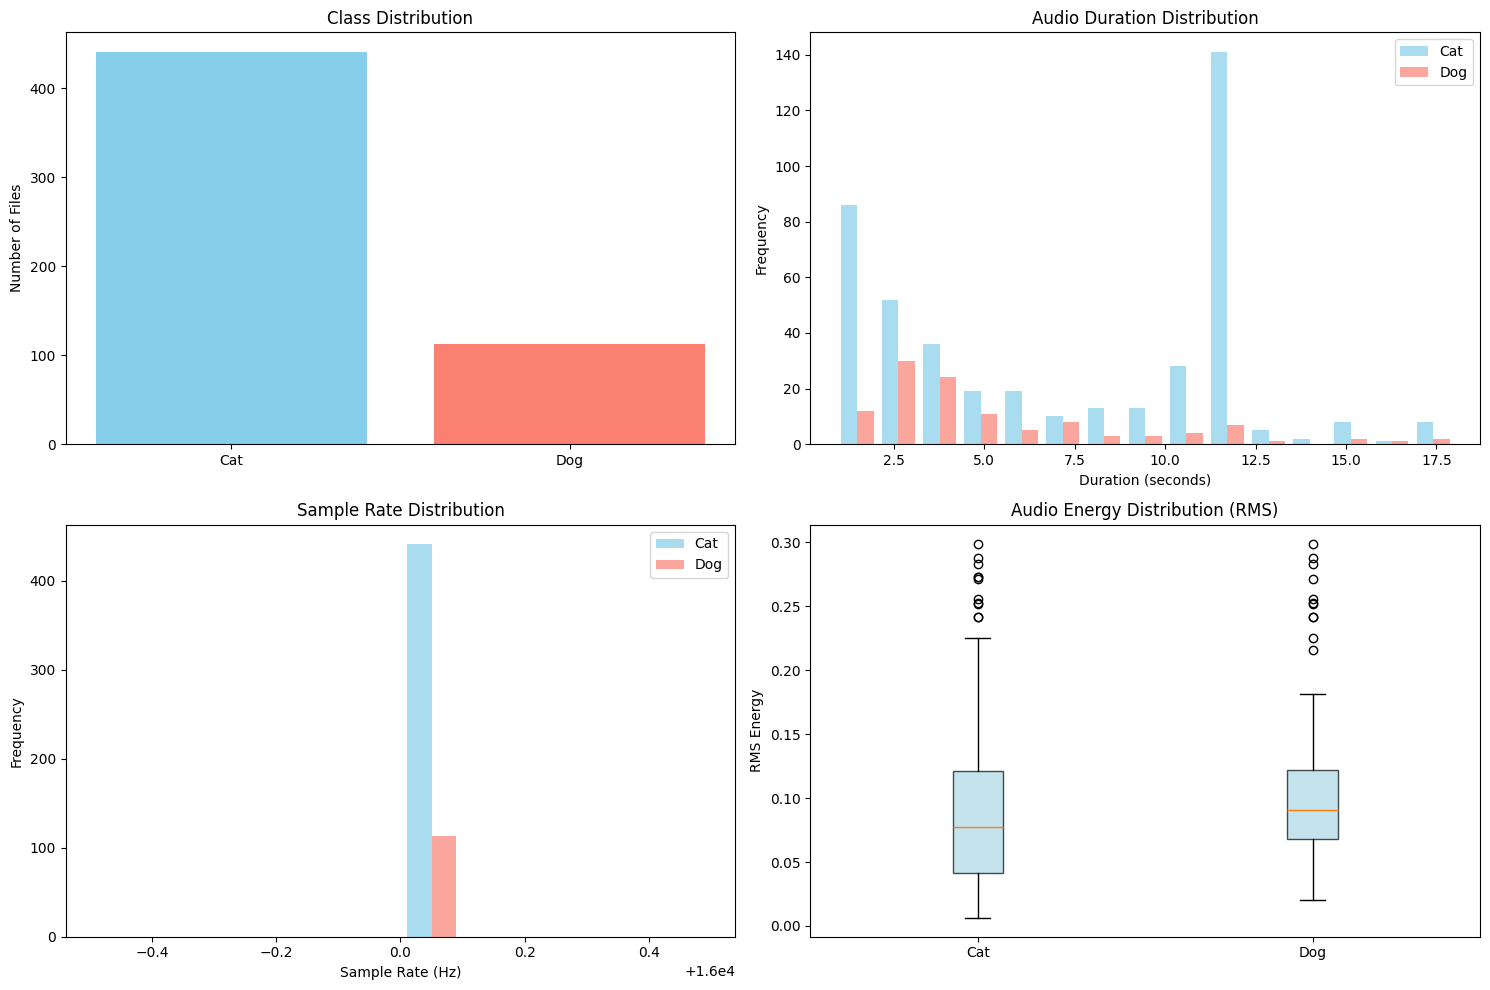

=== Dataset Summary ===
Total files: 554
Cat files: 441 (79.6%)
Dog files: 113 (20.4%)

Duration stats (seconds):
Mean: 6.94
Std: 4.58
Min: 0.92
Max: 17.98

Sample rates found: {16000}


In [5]:
audio_eda("data/cat_dog_audio")  

#### Analysis:

- Audio durations show two peaks : brief clips (~1–2 s) and longer calls (~12 s). Cats are more variable and dogs mostly short.

- Sample rates mix 16 kHz and 44 kHz -> resampling everything to 16 kHz. 

- Energy levels are similar across classes but with extreme outliers -> normalizing energy and removing noisy recordings.


#### Augmentation Tricks Used
- **Silence Trimming**: Removes quiet sections using librosa's trim function
-  **Adding Noise** :  Augment data by adding uniform noise to add variation to dataset.


## Supervised Contrastive:


 ****************************** supervised contrastive with over sampling Dog ****************************** 

Using device: cuda


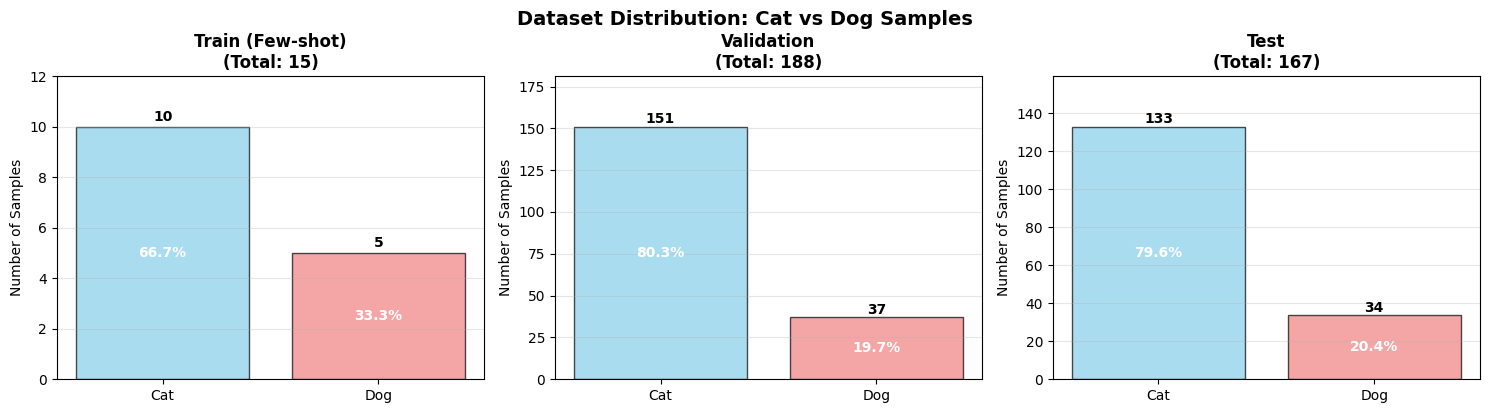


Dataset Distribution Summary:
----------------------------------------
Train (Few-shot): Cat=10, Dog= 5, Total=15
Validation     : Cat=151, Dog=37, Total=188
Test           : Cat=133, Dog=34, Total=167
Dataset sizes: {'train': 15, 'val': 188, 'test': 167}
Batch 0: size=8, labels=[1, 0, 1, 0, 0, 1, 0, 0]
Batch 1: size=7, labels=[0, 0, 0, 0, 1, 1, 0]
Processed 2/2 batches successfully


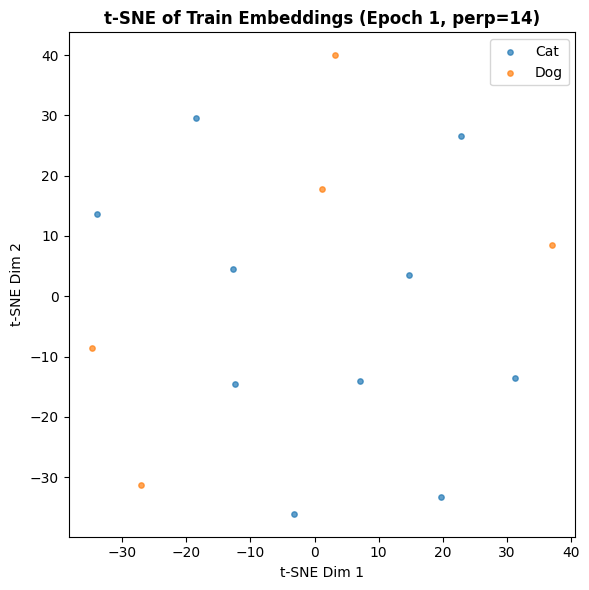

Epoch  1/10 | Train SupCon Loss=0.678 | Val Centroid Acc=0.761 | Val KNN Acc=0.809
Batch 0: size=8, labels=[0, 0, 0, 1, 0, 1, 0, 0]
Batch 1: size=7, labels=[1, 1, 0, 0, 0, 0, 1]
Processed 2/2 batches successfully


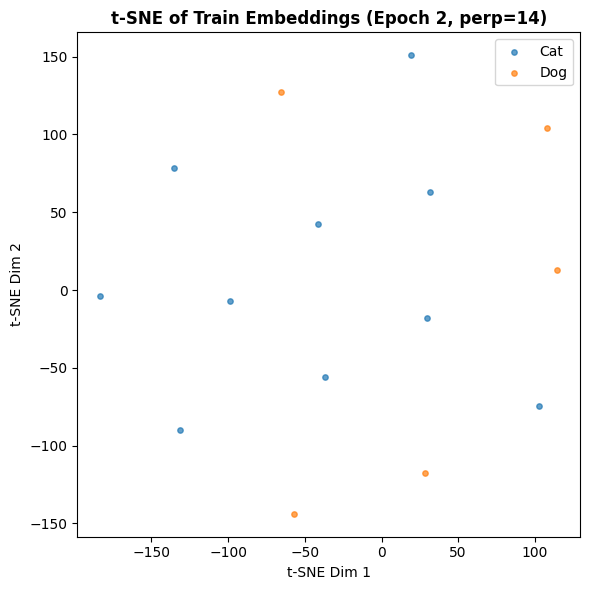

Epoch  2/10 | Train SupCon Loss=0.682 | Val Centroid Acc=0.739 | Val KNN Acc=0.809
Batch 0: size=8, labels=[1, 0, 0, 0, 1, 0, 1, 1]
Batch 1: size=7, labels=[0, 0, 0, 0, 0, 0, 1]
Processed 2/2 batches successfully


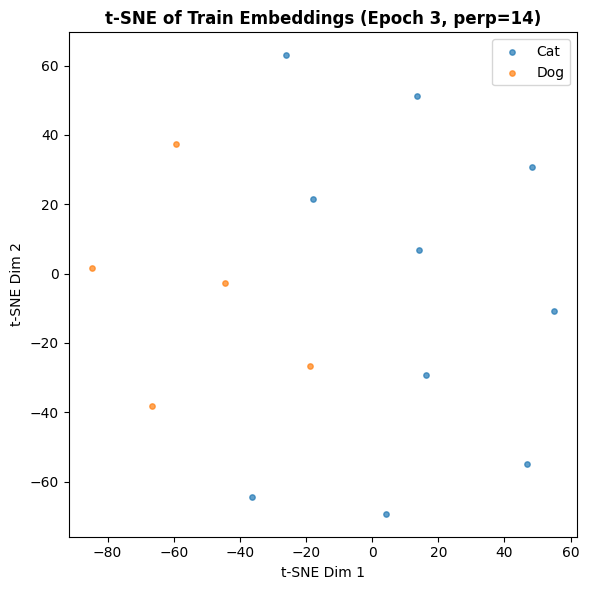

Epoch  3/10 | Train SupCon Loss=0.425 | Val Centroid Acc=0.782 | Val KNN Acc=0.803
Batch 0: size=8, labels=[0, 1, 1, 0, 0, 1, 0, 0]
Batch 1: size=7, labels=[0, 1, 0, 0, 0, 1, 0]
Processed 2/2 batches successfully


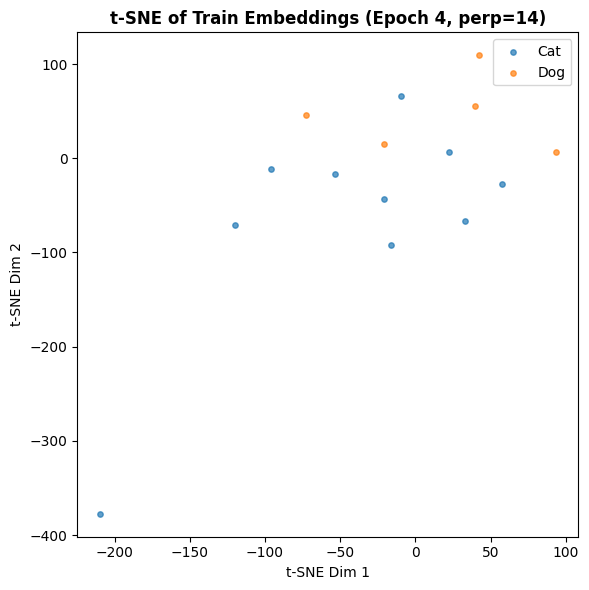

Epoch  4/10 | Train SupCon Loss=0.789 | Val Centroid Acc=0.793 | Val KNN Acc=0.793
Batch 0: size=8, labels=[1, 0, 0, 1, 0, 0, 1, 0]
Batch 1: size=7, labels=[0, 1, 0, 0, 1, 0, 0]
Processed 2/2 batches successfully


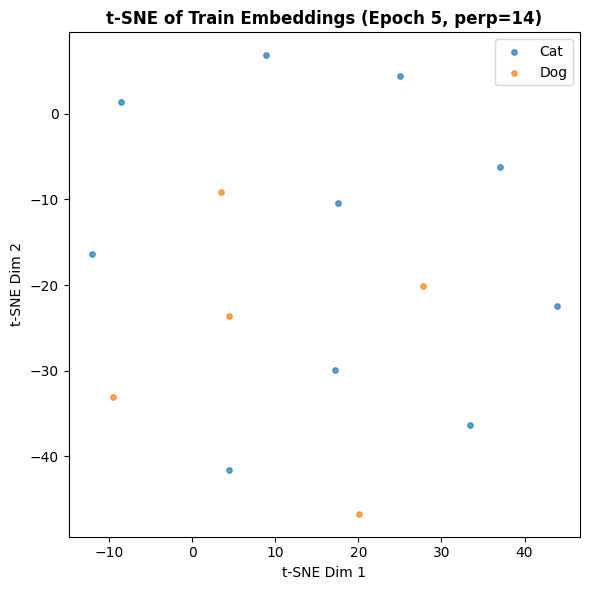

Epoch  5/10 | Train SupCon Loss=0.757 | Val Centroid Acc=0.793 | Val KNN Acc=0.803
Batch 0: size=8, labels=[0, 0, 0, 0, 1, 0, 1, 1]
Batch 1: size=7, labels=[1, 0, 0, 0, 0, 1, 0]
Processed 2/2 batches successfully


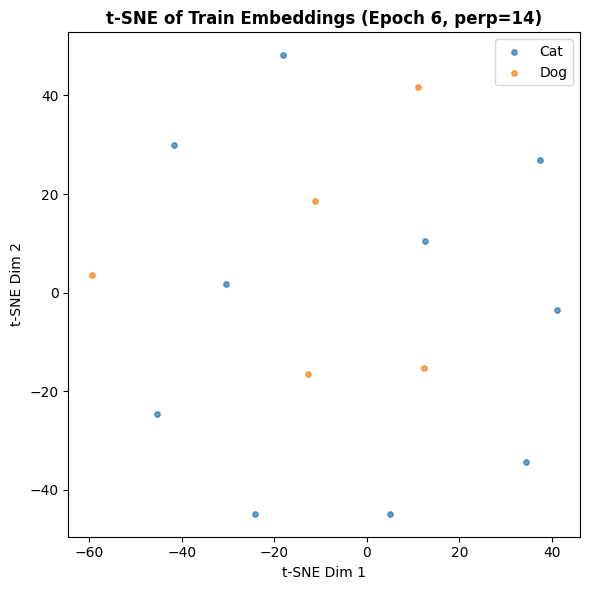

Epoch  6/10 | Train SupCon Loss=0.740 | Val Centroid Acc=0.761 | Val KNN Acc=0.798
Batch 0: size=8, labels=[0, 1, 1, 1, 0, 0, 0, 0]
Batch 1: size=7, labels=[0, 0, 1, 0, 0, 0, 1]
Processed 2/2 batches successfully


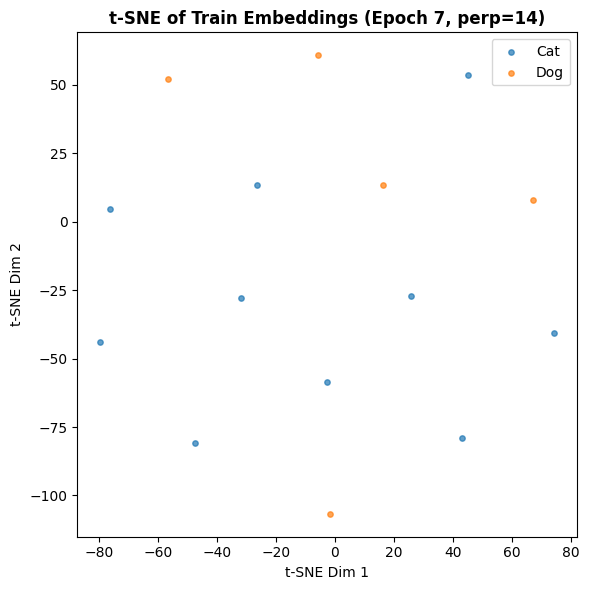

Epoch  7/10 | Train SupCon Loss=0.720 | Val Centroid Acc=0.755 | Val KNN Acc=0.798
Batch 0: size=8, labels=[1, 0, 1, 0, 0, 0, 0, 0]
Batch 1: size=7, labels=[0, 0, 0, 0, 1, 1, 1]
Processed 2/2 batches successfully


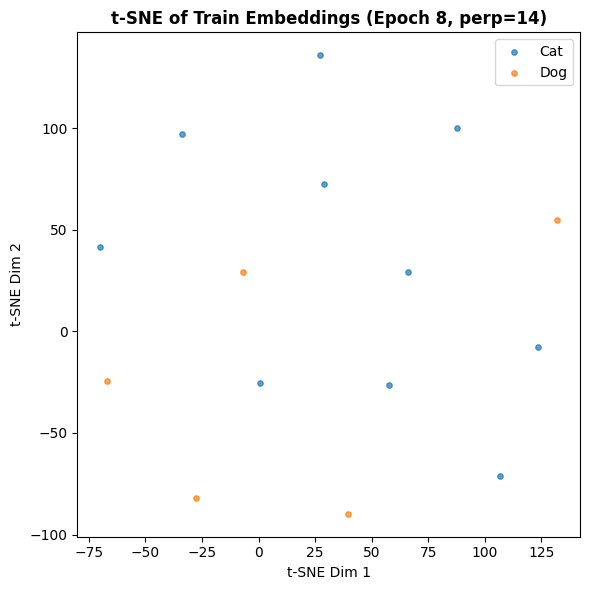

Epoch  8/10 | Train SupCon Loss=0.729 | Val Centroid Acc=0.787 | Val KNN Acc=0.798
Batch 0: size=8, labels=[0, 0, 0, 0, 1, 1, 0, 0]
Batch 1: size=7, labels=[0, 0, 1, 0, 1, 1, 0]
Processed 2/2 batches successfully


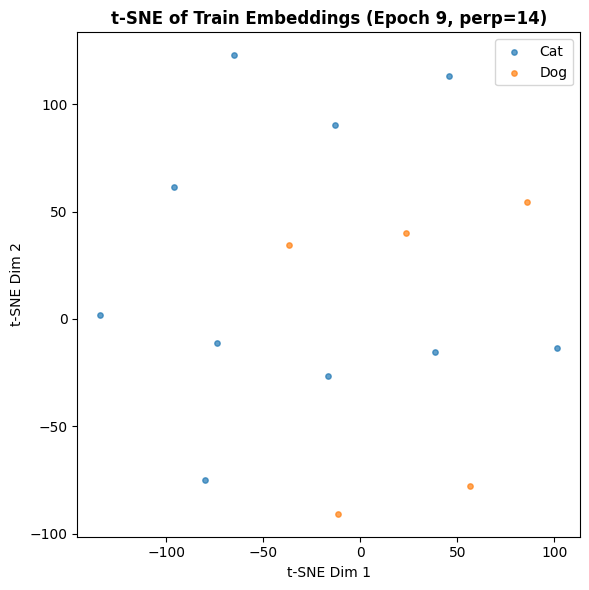

Epoch  9/10 | Train SupCon Loss=0.741 | Val Centroid Acc=0.793 | Val KNN Acc=0.798
Batch 0: size=8, labels=[1, 1, 0, 1, 1, 0, 0, 0]
Batch 1: size=7, labels=[0, 0, 1, 0, 0, 0, 0]
Processed 2/2 batches successfully


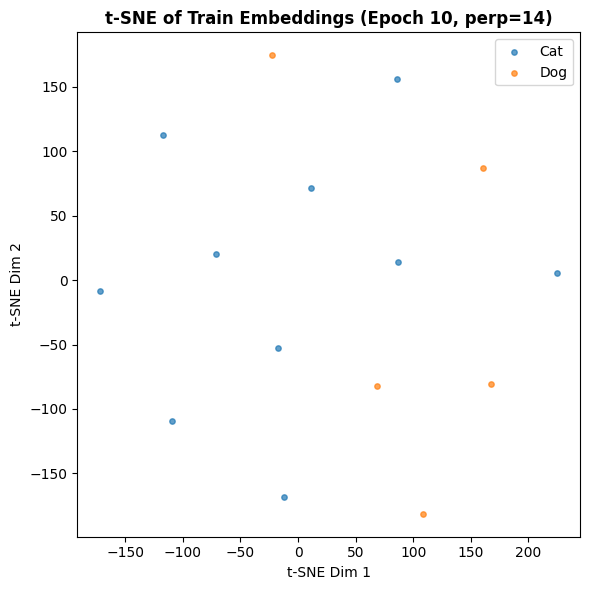

Epoch 10/10 | Train SupCon Loss=0.441 | Val Centroid Acc=0.782 | Val KNN Acc=0.803

Loaded model from best epoch 1 with val_acc=0.809


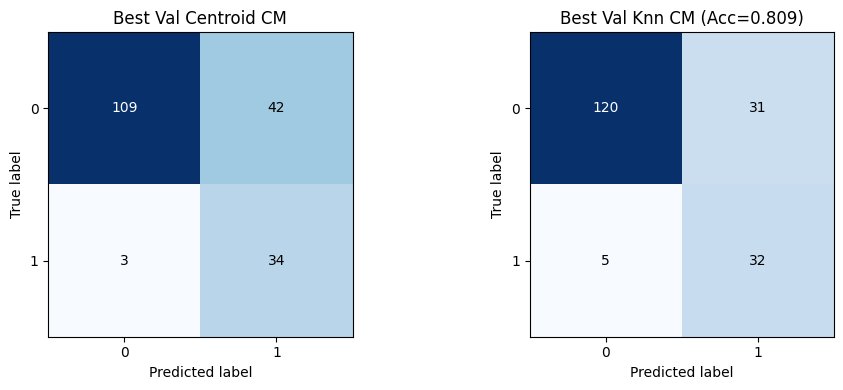

Final Results (Supervised Contrastive):
Test Centroid Acc: 0.754
Test Knn Acc: 0.766


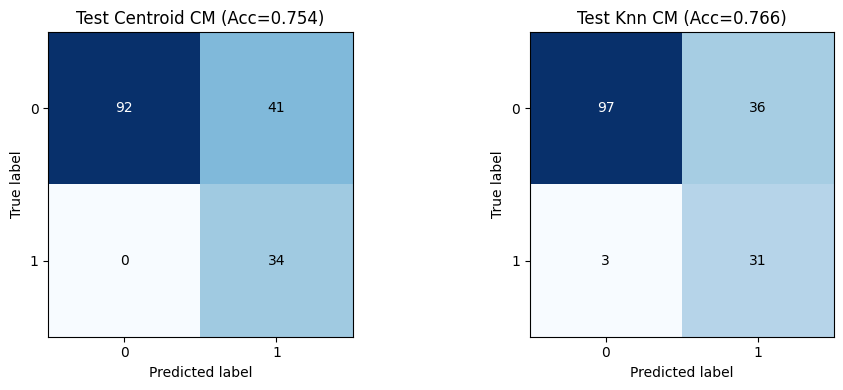

In [ ]:
model, results = train_supervised_contrastive_model(CONFIG)

## Contrastve with Triplet Loss:

Using device: cuda
Found 554 audio files: 441 cats, 113 dogs


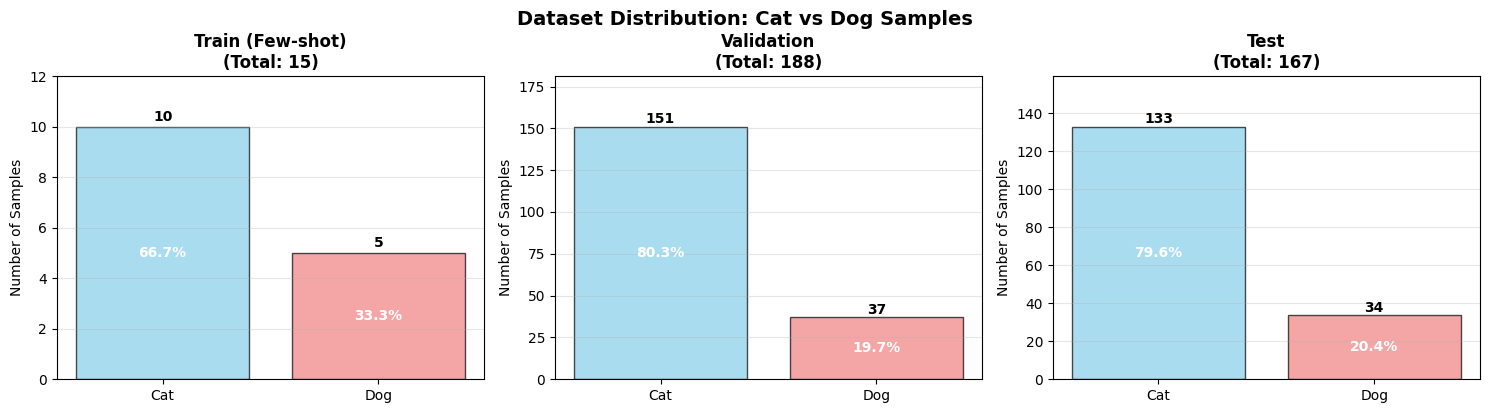


Dataset Distribution Summary:
----------------------------------------
Train (Few-shot): Cat=10, Dog= 5, Total=15
Validation     : Cat=151, Dog=37, Total=188
Test           : Cat=133, Dog=34, Total=167
Dataset sizes: {'train': 15, 'val': 188, 'test': 167}
Epoch  1/10 | Train Loss=0.488, Triplet Acc=0.667 | Val Centroid Acc=0.761 | Val KNN Acc=0.803
Epoch  2/10 | Train Loss=0.492, Triplet Acc=0.600 | Val Centroid Acc=0.766 | Val KNN Acc=0.787
Epoch  3/10 | Train Loss=0.484, Triplet Acc=0.933 | Val Centroid Acc=0.766 | Val KNN Acc=0.798
Epoch  4/10 | Train Loss=0.487, Triplet Acc=0.867 | Val Centroid Acc=0.766 | Val KNN Acc=0.793
Epoch  5/10 | Train Loss=0.482, Triplet Acc=0.800 | Val Centroid Acc=0.761 | Val KNN Acc=0.787
Epoch  6/10 | Train Loss=0.495, Triplet Acc=0.600 | Val Centroid Acc=0.766 | Val KNN Acc=0.793
Epoch  7/10 | Train Loss=0.487, Triplet Acc=0.733 | Val Centroid Acc=0.766 | Val KNN Acc=0.793
Epoch  8/10 | Train Loss=0.489, Triplet Acc=0.733 | Val Centroid Acc=0.761 | V

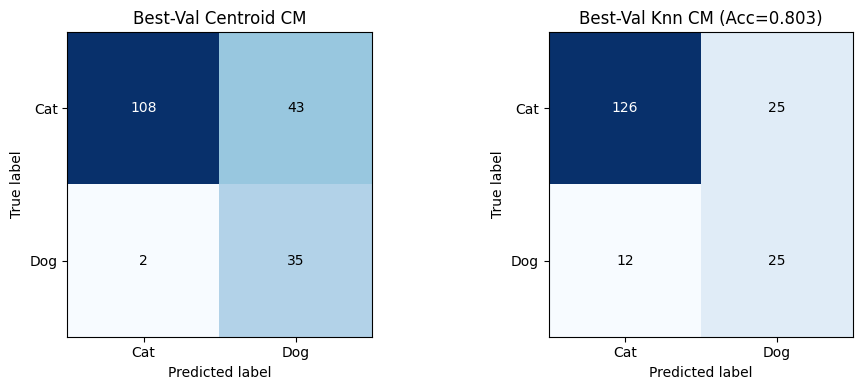


Final Results (Triplet Contrastive):
Test Centroid Acc: 0.743
Test Knn Acc: 0.743


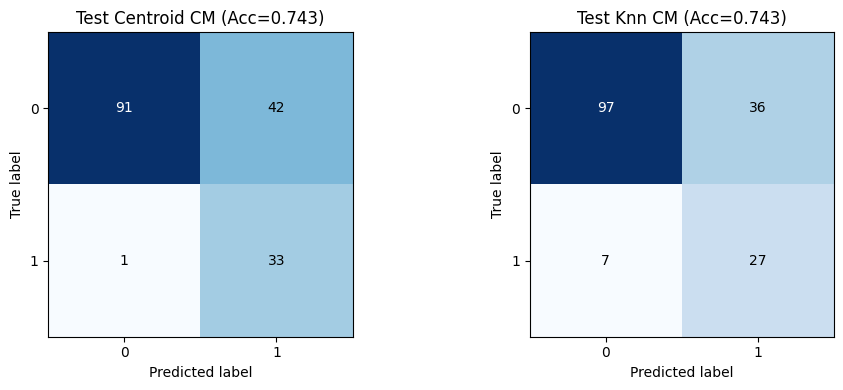

In [7]:
# Train using triplet-based contrastive loss
model, results = train_contrastive_model(CONFIG)


### Discussion

#### Duplicate Sampling Strategy
- Validation confusion matrices showed that cat embeddings were frequently misclassified as dogs.
- To tighten the cat cluster, ten cat examples were duplicated during training; five cat examples were duplicated to maintain approximate balance without diluting the dog signal.
- Upsampling cats forces the model to learn a denser cat embedding region.

#### Centroid-Based vs. k-NN Evaluation
- **Centroid Classification** 
  - Under both supervised and triplet contrastive, centroid yielded a substantial number of cat predicted as dog errors despite duplication, with triplet embeddings showing slightly looser separation overall.
- **k-Nearest Neighbors (k-NN)** 
  - For supervised contrastive embeddings, k-NN rescued had fewer cat predicted as dog errors, at the cost of only a few additional dog predicted as cat mistakes, resulting in improved overall accuracy.
  - For triplet contrastive embeddings, k-NN also corrected many cats but introduced a larger increase in dog predicted as cat errors.

#### Overall Performance
- The supervised contrastive approach consistently produced tighter, more balanced clusters, allowing k-NN to yield accuracy boost.
- Triplet contrastive embeddings remained less uniform; k-NN’s local corrections were offset by increased dog misclassifications.


#### Future Step:
We can explore can explore more `data augmentation` techiniques, `lora fine tuning + contrastive leraning`, using a different foundation model, etc.